<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/bolaso2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np

import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [2]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [ ]:
df_original.describe()

In [ ]:
ax = df_original.hist(bins=20, figsize=(15, 10))

In [3]:
def train_val_test_split(df, train_percent, validate_percent, seed):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [4]:
#train_percent = 0.7
#val_percent = 0.15

#df_train, df_val, df_test = train_val_test_split(df_original,train_percent, val_percent, SEED)

In [29]:
y = df_original.pop("ingreso")
X = df_original.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [98]:
print('Todo: ',df_original.shape)
print('Train:',df_train.shape)
print('Val:  ',df_val.shape)
print('Test: ',df_test.shape)

Todo:  (40000, 25)
Train: (28000, 25)
Val:   (6000, 25)
Test:  (6000, 25)


se remplazan los null por la media de la columna

In [30]:
edad_media = X_test['edad'].mean()

In [6]:
def transfromar_DataFrame (df,edad_media):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2B','3').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  return df

In [31]:
X_train = transfromar_DataFrame(X_train,edad_media)
X_test = transfromar_DataFrame(X_test,edad_media)
#df_val = transfromar_DataFrame(df_val,edad_media)

In [8]:
#y_train = df_train.pop("ingreso")
#X_train = df_train.copy()
#y_test = df_test.pop("ingreso")
#X_test = df_test.copy()
#y_val = df_val.pop("ingreso")
#X_val = df_val.copy()

In [32]:
# La linea base es el mediana de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
mediana = y_train.median()
baseline_preds['mediana'] = mediana

baseline_MAPE = MAPE(y_train,baseline_preds['mediana'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))
print('Mediana de ingreso: ', round(mediana))

MAPE linea base:  42.18
Mediana de ingreso:  53665


In [33]:
model_1_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 500,
            learning_rate = 0.01,
            max_depth = 10,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.8,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )

In [34]:
model_1_xgb.fit(X_train,y_train)
preds_xgb = model_1_xgb.predict(X_test)
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 12.63


Text(0.5, 0, 'Xgboost Feature Importance')

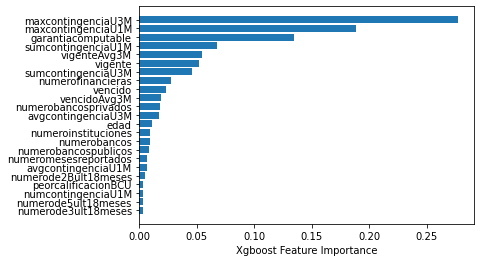

In [35]:
sorted_idx = model_1_xgb.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model_1_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [36]:
rf = RandomForestRegressor(n_estimators = 500, random_state = SEED)
rf.fit(X_train,y_train)
preds_rf = rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.94


Se hace la prueba de una regresión lineal con las columnas más influyentes

In [60]:
X_train_LR = X_train[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]
X_test_LR = X_test[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]

In [61]:
pipe_LR = Pipeline([('scaler',StandardScaler()),('model',LR())])
pipe_LR.fit(X_train_LR,y_train)
preds_LR = pipe_LR.predict(X_test_LR)
MAPE_LR = MAPE(y_test, preds_LR)
print('MAPE_LR:', round(100*MAPE_LR, 2))

MAPE_LR: 19.54


lo mismo con knn

In [43]:
pipe_KNN = Pipeline([('scaler',StandardScaler()),('model',KNN(n_neighbors=15))])
pipe_KNN.fit(X_train_LR,y_train)
preds_KNN = pipe_KNN.predict(X_test_LR)
MAPE_KNN = MAPE(y_test, preds_KNN)
print('MAPE_KNN:', round(100*MAPE_KNN, 2))

MAPE_KNN: 14.93


In [44]:
acc_xgb=1-MAPE_xgb
acc_rf=1-MAPE_rf
acc_LR=1-MAPE_LR
acc_KNN=1-MAPE_KNN
print(acc_xgb,acc_rf,acc_LR,acc_KNN)

0.8737122426938504 0.8705707855291397 0.8045963004676079 0.8507348649252754


In [46]:
preds_total = pd.DataFrame()
preds_total['xgb'] = preds_xgb
preds_total['rf'] = preds_rf
preds_total['LR'] = preds_LR
preds_total['KNN'] = preds_KNN
preds_total['Promedio'] = (preds_total.xgb + preds_total.rf + preds_total.LR + preds_total.KNN)/4
preds_total['Ponderado'] = (preds_total.xgb*acc_xgb + preds_total.rf*acc_rf + preds_total.LR*acc_LR + preds_total.KNN*acc_KNN)/(acc_xgb+acc_rf+acc_LR+acc_KNN)
preds_total.head()

,xgb,rf,LR,KNN,Promedio,Ponderado
0,56225.871094,53903.396886,59269.133714,57696.117879,56773.629893,56719.311906
1,46163.406250,48219.846776,55822.080773,45979.916741,49046.312635,48930.046056
2,44002.527344,44794.256867,45679.029481,43580.524208,44514.084475,44496.451407
3,42090.472656,42940.701396,39625.365877,40425.445925,41270.496464,41308.110907
4,38738.718750,39970.249642,45698.412715,39221.046605,40907.106928,40821.958465


In [47]:
MAPE_promedio = MAPE(y_test, preds_total['Promedio'])
print('MAPE_KNN:', round(100*MAPE_promedio, 2))
MAPE_pond = MAPE(y_test, preds_total['Ponderado'])
print('MAPE_KNN:', round(100*MAPE_pond, 2))

MAPE_KNN: 13.53
MAPE_KNN: 13.47


In [ ]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

In [ ]:
df_test = transfromar_DataFrame(df_test_original)


In [ ]:
d_test = xgb.DMatrix(df_test)

In [ ]:
preds_datathon = best_model.predict(d_test)

In [ ]:
pd.DataFrame(preds_datathon).to_csv('predicciones.csv') 